# **RandomForrest**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
#tf.compat.v1.disable_v2_behavior()

import gc

2023-05-17 20:15:41.075042: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-17 20:15:41.075071: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-17 20:15:41.932341: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-05-17 20:15:41.932434: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-05-17 20:15:41.932444: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT War

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed May 17 20:15:42 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 390.157                Driver Version: 390.157                   |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  NVS 5400M           Off  | 00000000:01:00.0 N/A |                  N/A |
| N/A   54C    P0    N/A /  N/A |    179MiB /   964MiB |     N/A      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
# Mount the Drive
path=[]
LOCAL = True
if LOCAL:
    path = './content/'
else:    
    from google.colab import drive
    drive.mount('/content/drive')
    path='/content/drive/MyDrive/Colab Notebooks/content/'

In [54]:
df0 = pd.read_csv(f'{path}/data_homes.csv', low_memory=False)
df1 = pd.read_csv(f'{path}/Assessments_vs_Sales.csv')

# **Prepare data**

In [56]:
# add a KEY to corralate our datasets
df0['KEY'] = df0.PRINT_KEY+df0.SALE_DATE + df0['SALE_PRICE_LOG10'].apply(lambda x: round(10**x)).astype(str)
df1['KEY'] = df1.PRINT_KEY+df1.SALE_DATE + (df1['SALE_PRICE']).apply(lambda x: round(x)).astype(str)
df0['KEY'].head()

0    002.-05-19.02016-12-13 11:24:0656306
1    002.-06-09.02005-07-29 00:00:0061000
2    002.-06-09.02015-05-14 10:38:1555000
3    002.-06-10.02006-01-23 00:00:0045000
4    002.-06-12.02007-01-10 00:00:0067000
Name: KEY, dtype: object

In [6]:
# Add a timestamp to our data
import datetime
df0['SALE_TIMESTAMP'] = df0['SALE_DATE'].apply(pd.to_datetime)
df0['SALE_TIMESTAMP'] =df0['SALE_TIMESTAMP'].apply(datetime.datetime.timestamp)

df1['SALE_TIMESTAMP'] = df1['SALE_DATE'].apply(pd.to_datetime)
df1['SALE_TIMESTAMP'] =df1['SALE_TIMESTAMP'].apply(datetime.datetime.timestamp)

In [7]:
# Drop our duplicate properties
# We ought to be more careful here because of potential bias
df = df0.copy() # save a copy for further analysis 

# Check for dup records
print(f'Duplicates: {df1[df1.duplicated(subset=["KEY"])]}') # no complete dups

# Check for dup keys
unique_index = df['KEY'].unique().tolist()
print(f'Dup Indices: {len(df)-len(unique_index)}')

dup_keys = df[df.duplicated(subset=['KEY'])].index

df.loc[df['KEY'].isin(dup_keys)].index
print(dup_keys)

Duplicates: Empty DataFrame
Columns: [PRINT_KEY, SALE_DATE, SALE_PRICE, MARKET_VAL, KEY, SALE_TIMESTAMP]
Index: []
Dup Indices: 10
Int64Index([471, 3329, 3934, 4692, 6132, 6386, 10341, 12032, 13119, 13381], dtype='int64')


In [8]:
#df.drop(i, inplace=True) # See Appendix 1. Bias in Data Types
df0.drop(dup_keys, inplace=True)
len(df) , len(df0)

(14471, 14461)

In [9]:
def report_missing(df):
    for col in list(df.columns):
        if (df[col].isnull().sum()!=0):
          print(f'{col}: {len(df[col].unique())} (Missing: {df[col].isnull().sum()})')
          if (len(df[col].unique()) <=7):
            print(f'\t{df[col].unique()}')

In [10]:
def clean_df(df):
  df0 = df.copy()

  # DROP List
  drop_list = ['issue_date', 'valuation', 'USED_AS_CD', 'TOTAL_RENT_AREA', 'PRINT_KEY', 'SALE_DATE', 'KEY']
  df0.drop(columns=drop_list, axis=1, inplace=True, errors='ingore')

  # IMPUTE 
  df0['WalkIndex'].fillna(float(df0['WalkIndex'].mode()), inplace = True)
  df0['buildings_300m'].fillna(float(df0['buildings_300m'].mode()), inplace = True)
  df0['FRONT_LOG10'].fillna(float(df0['FRONT_LOG10'].min()), inplace = True)
  df0['DEPTH_LOG10'].fillna(float(df0['DEPTH_LOG10'].min()), inplace = True)
  df0['AREA_PARCEL_RECT_LOG10'].fillna(float(df0['AREA_PARCEL_RECT_LOG10'].min()), inplace = True)
  report_missing(df0)
  return df0
df0 = clean_df(df0)

In [11]:
def prepare(df):
  # Drop
  y = df.SALE_PRICE_LOG10.to_numpy()

  df_ = df.copy()
  df_.drop(columns=['SALE_PRICE_LOG10'], inplace=True, errors='ignore')
  
  X = df_.to_numpy()
  #X= np.expand_dims(X, -1)
  return X, y

In [12]:
from sklearn.model_selection import train_test_split

X, y = prepare(df0)
# again we are splitting our data after normalization... not the best practice!
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2) #, random_state=42)

# **Model**

In [13]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris

#!pip install lime
import lime
import lime.lime_tabular

import warnings
warnings.filterwarnings("ignore")

In [14]:
y_train[0]

5.225309281725863

In [15]:
gbr = GradientBoostingRegressor()
gbr.fit(x_train, y_train)

GradientBoostingRegressor()

In [16]:
gbr.score(x_test, y_test)

0.7291599887417783

In [17]:
def get_cats(df):
    cats = []
    for col in list(df.columns):
        if (len(df[col].unique()) <=10):
            cats.append(col)
    return cats

categorical_features = get_cats(df0)
feature_names = df0.columns.to_list()
#print(feature_names)

# **Explainer**

In [18]:
from lime.lime_tabular import LimeTabularExplainer
explainer = LimeTabularExplainer(x_train,
    feature_names=feature_names,
    class_names=['price'],
    categorical_features=categorical_features,
    mode='regression')

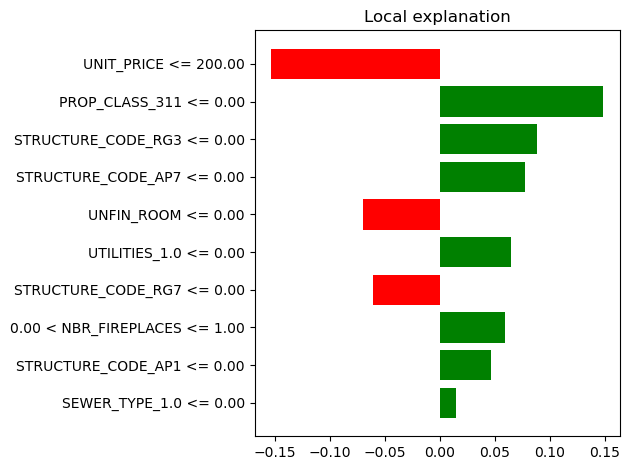

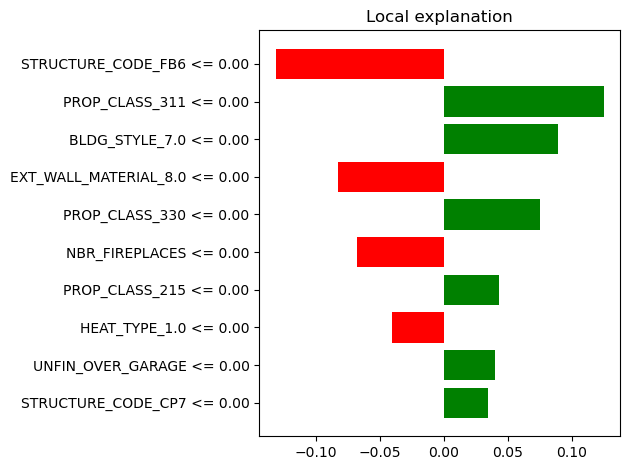

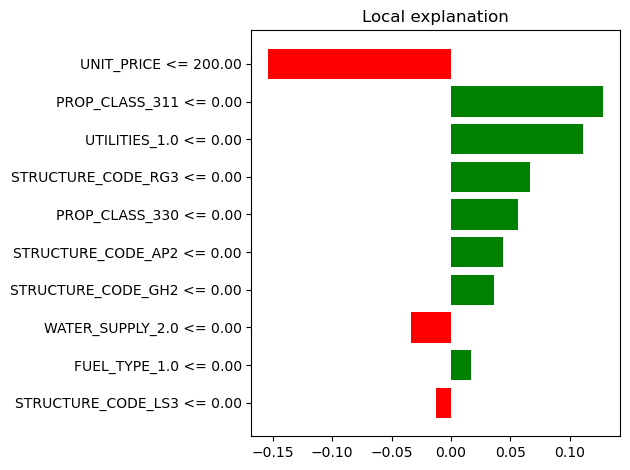

In [19]:
for i in [7, 50, 66]:
    exp = explainer.explain_instance(x_test[i], gbr.predict,
            num_features=10)
    exp.as_pyplot_figure()
    plt.tight_layout()

# **Prediction**

In [20]:
from sklearn.metrics import mean_squared_error
predictions = gbr.predict(x_test)
mean_squared_error(y_test, predictions)

0.013236855944847692

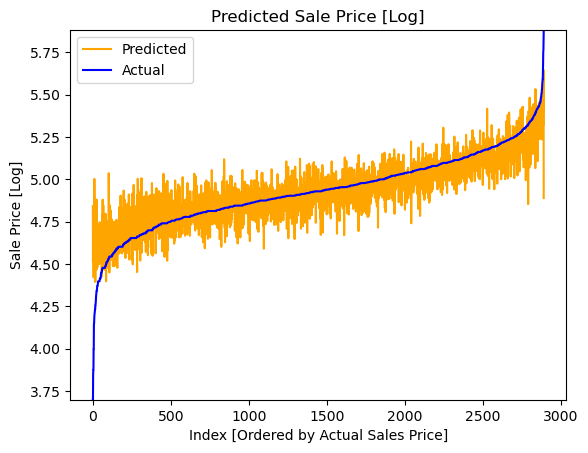

In [21]:
sorted_index = np.argsort(y_test)

yy = []
y_hat = []
mv = []
for i,si in enumerate(sorted_index):
  yy.append(y_test[si])
  y_hat.append(predictions[si])

plt.ylim(y_test.min(),y_test.max())

plt.title('Predicted Sale Price [Log]')
plt.xlabel('Index [Ordered by Actual Sales Price]')
plt.ylabel('Sale Price [Log]')

plt.plot(np.array(y_hat),c= 'orange', label='Predicted')
plt.plot(np.array(yy), c= 'blue', label='Actual')
plt.legend();

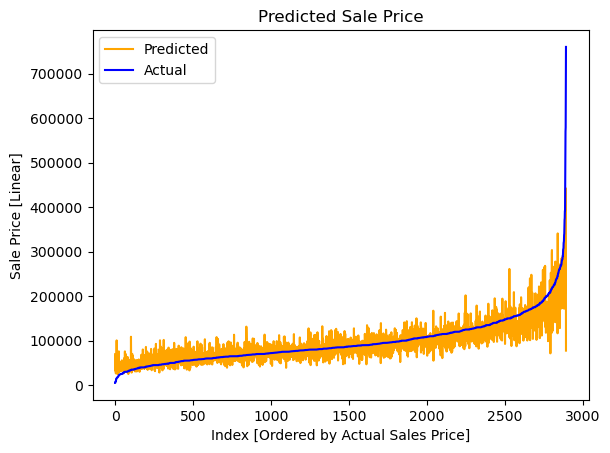

In [22]:
plt.title('Predicted Sale Price')
plt.xlabel('Index [Ordered by Actual Sales Price]')
plt.ylabel('Sale Price [Linear]')

plt.plot(10**np.array(y_hat),c= 'orange', label='Predicted')
plt.plot(10**np.array(yy), c= 'blue', label='Actual')
plt.legend();

In [63]:
# Recall our correlated indices...
my_index = df['KEY'].to_list()
my_index = df1.loc[df1['KEY'].isin(my_index)]['KEY'].to_list()
len(my_index)

df0_ = df.loc[df['KEY'].isin(my_index)]
df1_ = df1.loc[df1['KEY'].isin(my_index)]
df0_.drop(dup_keys, inplace=True)
len(df0_), len(df1_), len(df0_.columns)

(7109, 7109, 147)

In [61]:
'''# Recall our correlated indices...
my_index = df0['KEY'].to_list()
my_index = df1.loc[df1['KEY'].isin(my_index)]['KEY'].to_list()
#my_index = df1.loc[df1['KEY'].isin(my_index)]['KEY'].to_list()
#my_index= sorted(my_index)

# FIX ME!! too tired
df0_ = df0.loc[df['KEY'].isin(my_index)]
df1_ = df1.loc[df1['KEY'].isin(my_index)]
len(my_index), len(df0_), len(df1_)
''';

(7109, 7119, 7109)

In [76]:
# FIX up order
df0_.sort_values(by=['KEY'],inplace=True)
df1_.sort_values(by=['KEY'],inplace=True)
display(df0_.KEY.head())
display(df1_.KEY.head())

0    002.-05-19.02016-12-13 11:24:0656306
2    002.-06-09.02015-05-14 10:38:1555000
5    002.-07-13.02009-11-17 15:01:2654000
7    002.-07-27.02008-01-10 00:00:0066900
9    002.-08-11.02008-09-10 12:36:2763600
Name: KEY, dtype: object

5115    002.-05-19.02016-12-13 11:24:0656306
3910    002.-06-09.02015-05-14 10:38:1555000
1148    002.-07-13.02009-11-17 15:01:2654000
14      002.-07-27.02008-01-10 00:00:0066900
505     002.-08-11.02008-09-10 12:36:2763600
Name: KEY, dtype: object

In [77]:
#KeyError: "['issue_date', 'valuation', 'USED_AS_CD', 'TOTAL_RENT_AREA', 'PRINT_KEY', 'SALE_DATE', 'KEY'] not found in axis"
KeyError = ['issue_date', 'valuation', 'USED_AS_CD', 'TOTAL_RENT_AREA', 'PRINT_KEY', 'SALE_DATE', 'KEY']
for k in KeyError:
    df0_[k] = df0_['SALE_PRICE_LOG10']

df_new = clean_df(df0_)
X, y = prepare(df_new)

In [81]:
y_hat = gbr.predict(X) 
#y_assess = df1_['SALE_PRICE'].apply(np.log10).to_numpy()
y_assess = df1_['MARKET_VAL'].apply(np.log10).to_numpy()

len(y_assess), len(y_hat)

(7109, 7109)

In [82]:
y_assess[0], y_hat[0], y[0]

(4.585026652029182, 4.734912136597295, 4.75055467598901)

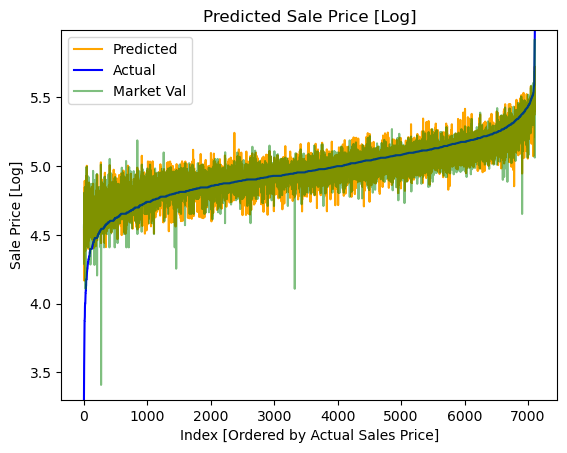

In [84]:
# plot a comparison
sorted_index = np.argsort(y) # sort by actual

yy = []
yy_hat = []
yy_assess = []
for i,si in enumerate(sorted_index):
  yy.append(y[si])
  yy_hat.append(y_hat[si])
  yy_assess.append(y_assess[si])

plt.ylim(y.min(),y.max())

plt.title('Predicted Sale Price [Log]')
plt.xlabel('Index [Ordered by Actual Sales Price]')
plt.ylabel('Sale Price [Log]')

plt.plot(np.array(yy_hat),c= 'orange', label='Predicted')
plt.plot(np.array(yy), c= 'blue', label='Actual')
plt.plot(np.array(yy_assess), c= 'green', label='Market Val',alpha=0.5)
plt.legend();

# **Duplicate Record Analysis**

In [ ]:
dup_i = list(dup_keys)
dup_i

In [ ]:
dup_k = df.iloc[dup_i].KEY.to_list()
len(dup_k)

In [ ]:
df_dup = df.loc[df['KEY'].isin(dup_k)]
len(df_dup)

In [ ]:
# DROP strings
df_dup.drop(columns=['KEY', 'PRINT_KEY', 'SALE_DATE', 'issue_date'], axis=1, inplace=True, errors='ignore')
display(df_dup.head(2))

In [ ]:
df_i = list(df_dup.index)
#df_i

In [ ]:
# there is probably a better way to do this 
cols = list(df_dup.columns)
#print(cols)

for i in range( (len(df_i)//2)):
    #print(f'{i*2}, {i*2+1}, {df_i[i*2]}, {df_i[i*2+1]}')   
    #display(df_dup.iloc[i*2])
    print(f'\n{df_i[i*2]}-{df_i[i*2+1]}:')
    for c in cols:
        dd = df_dup.iloc[i*2][c]-df_dup.iloc[i*2+1][c]
        if dd != 0:
            print(f'\t{c}: \t{dd}')


## **Observations**
    This columns are being dropped because so few records contain them.  Thus our decision to remove this columns is valid.

# **Missing Record Analysis**

In [ ]:
df1_missing = df1.loc[~df1['KEY'].isin(my_index)]
len(df1_missing)

In [ ]:
df1_missing[['SALE_DATE', 'SALE_PRICE', 'SALE_TIMESTAMP']]

In [ ]:
sp_list = list(round(df1_missing.SALE_PRICE)) # round in a simular manner
#sp_list

In [ ]:
# Add a SALE_PRICE to our df... round is going to be tricky
df_ = df.copy()
df_['SALE_PRICE_ROUND'] = df_.SALE_PRICE_LOG10.apply(lambda x: round(10**x))

In [ ]:
len(df_.loc[df_['SALE_PRICE_ROUND'].isin(sp_list)]) # a needle in haystack

In [ ]:
ts_list = df1_missing.SALE_TIMESTAMP
#len(ts_list)

In [ ]:
len(df_.loc[df_['SALE_TIMESTAMP'].isin(ts_list)])
#df_.loc[df_['SALE_TIMESTAMP'].isin(ts_list)][['SALE_PRICE_ROUND', 'SALE_TIMESTAMP']]

In [ ]:
pk_list = df1_missing.PRINT_KEY
#len(pk_list)

In [ ]:
len(df_.loc[df_['PRINT_KEY'].isin(pk_list)])
#df_.loc[df_['PRINT_KEY'].isin(pk_list)][['SALE_PRICE_ROUND','PRINT_KEY']]

In [ ]:
# This are the only possible records that we might be able to resolve...
hs_list = set(df_.loc[df_['SALE_TIMESTAMP'].isin(ts_list)].index)
hs_list = hay_stack.union(set(list(df_.loc[df_['PRINT_KEY'].isin(pk_list)].index)))
hs_list = list(hs_list)

In [ ]:
len(hs_list)  # a must smaller haystack
df_haystack = df_.iloc[hs_list]

In [ ]:
len(df_haystack[df_haystack['SALE_PRICE_ROUND'].isin(sp_list)]) # a needle in haystack
# here are the 16 needles! how cool is that?!

In [ ]:
sp_poss = list(df_haystack[df_haystack['SALE_PRICE_ROUND'].isin(sp_list)].SALE_PRICE_ROUND)
df_haystack[df_haystack['SALE_PRICE_ROUND'].isin(sp_list)].SALE_PRICE_ROUND

In [ ]:
df1_missing['SALE_PRICE_ROUND'] = df1_missing.SALE_PRICE.apply(lambda x: round(x))
len(df1_missing.loc[df1_missing['SALE_PRICE_ROUND'].isin(sp_poss)]) # lol, 6 are non-unique

In [ ]:
df1_missing.loc[df1_missing['SALE_PRICE_ROUND'].isin(sp_poss)]